In [35]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uniprot
from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [2]:
seqids, fastas = uniprot.read_fasta('/Users/daniel/desktop/cp341/uniprot_sprot.fasta')

In [3]:
len(seqids)

568002

In [34]:
species = set()
for seqid in seqids:
    temp = [x for x, j in enumerate(fastas[seqid]['description'].split()) if j[0:3] == "OS="][0]
    #print(temp)
    try:
        #print()
        #print(temp)
        first_part = fastas[seqid]['description'].split()[temp]
        if fastas[seqid]['description'].split()[temp+1][0:3] != "OX=":
            first_part += " " + fastas[seqid]['description'].split()[temp+1][0:3]
        species.add(first_part)
    except IndexError:
        print(fastas[seqid])
        print(temp)
        break

species

{'OS=Mycobacterium kan',
 'OS=Spermophilus cit',
 'OS=Drosophila mel',
 'OS=Brachybacterium fae',
 'OS=Micronycteris gio',
 'OS=Mycetinis sco',
 'OS=Haemophilus aeg',
 'OS=Sorex pal',
 'OS=Steatomys par',
 'OS=Solenopsis amb',
 'OS=Streptosporangium sib',
 'OS=Ochotona for',
 'OS=Bordetella pet',
 'OS=Methanococcoides met',
 'OS=Streptomyces ros',
 'OS=Bubalus dep',
 'OS=Acrantophis mad',
 'OS=Bacillus saf',
 'OS=Saimiri sci',
 'OS=Odorrana gra',
 'OS=Streptomyces hyg',
 'OS=Echovirus 12',
 'OS=Limnospira max',
 'OS=Thomomys maz',
 'OS=Hydrolagus col',
 'OS=Plutella xyl',
 'OS=Carcharias tau',
 'OS=Oryzias cur',
 'OS=Burkholderia tha',
 'OS=Thiocapsa pen',
 'OS=Amaryllis bel',
 'OS=Phrynops hil',
 'OS=Megascolia fla',
 'OS=Acinetobacter pha',
 'OS=Sulcia mue',
 'OS=Thermasporomyces com',
 'OS=Cyrilla rac',
 'OS=Lophodytes cuc',
 'OS=Plasmodium yoe',
 'OS=Lynx lyn',
 'OS=Haementeria dep',
 'OS=Loxosceles spa',
 'OS=Sminthopsis ool',
 'OS=Calocitta for',
 'OS=Suaeda sal',
 'OS=Rosa foe',

In [23]:
len(species)

5385

In [33]:
fastas['sp|P09430']['description']
temp = [x for x, j in enumerate(fastas['sp|P09430']['description'].split()) if j[0:3] == "OS="][0]
print(temp)
fastas['sp|P09430']['description'].split()[temp]
fastas['sp|P09430']['description'].split()[temp+1]
fastas['sp|P09430']['description'].split()[temp+2]

7


'OX=9606'

In [25]:
[x for x in fastas['sp|P09430']['description'].split() if x[0:2] == "OS="]

['OS=Homo']

In [6]:
analysis = ProteinAnalysis(fastas[seqids[0]]['sequence'])

In [8]:
analysis.molecular_weight()

29735.10070000003

In [36]:
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm1b_t33_650M_UR50S")

Using cache found in /Users/daniel/.cache/torch/hub/facebookresearch_esm_main


In [37]:
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
    ("protein3",  "K A <mask> I S Q")
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

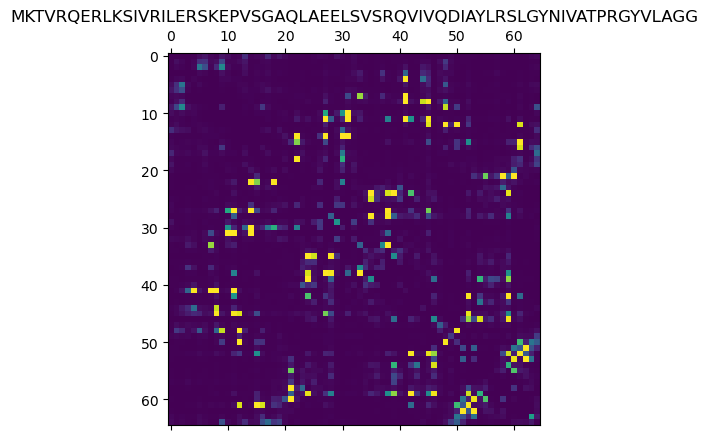

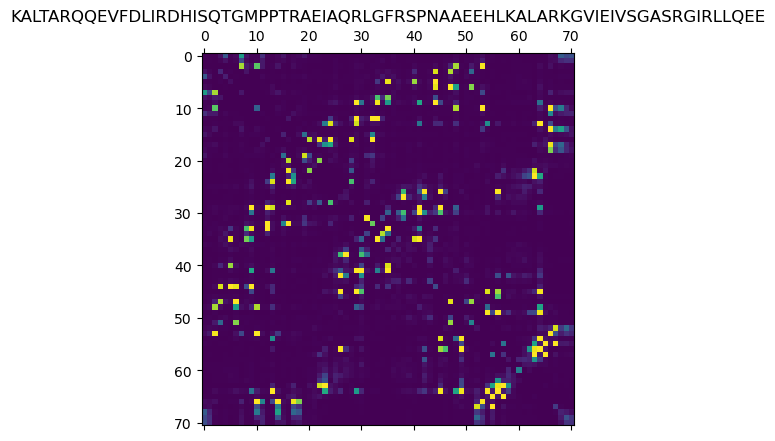

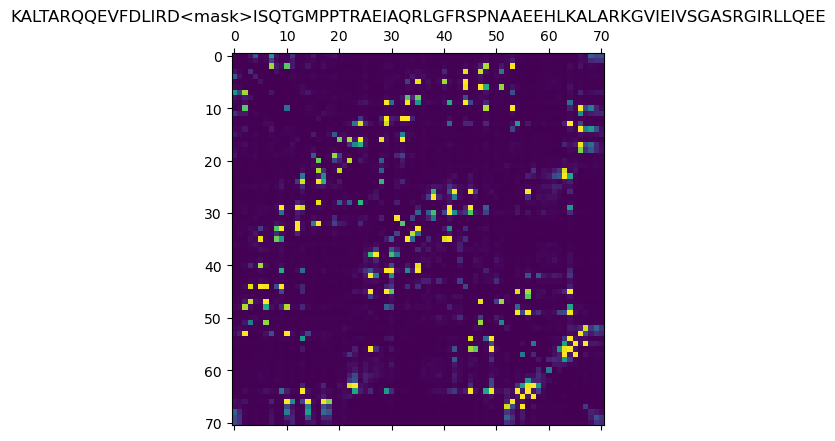

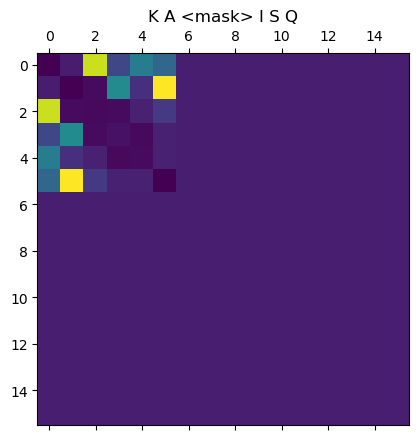

In [5]:
# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, (_, seq) in enumerate(data):
    sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))

# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), attention_contacts in zip(data, results["contacts"]):
    plt.matshow(attention_contacts[: len(seq), : len(seq)])
    plt.title(seq)
    plt.show()

In [13]:
sequence_representations[3].shape

torch.Size([1280])

In [17]:
token_representations[3].shape

torch.Size([73, 1280])